<a href="https://colab.research.google.com/github/albey-code/hippoabstraction/blob/main/parameter_recovery_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approach 1: Distinguishability of γ through SR matrices

**Parameter recovery** is a method used in computational modeling to test whether the parameters of a model (like γ in the successor representation (SR) model) can be accurately estimated from data.

Why is this important? Even if my SR model fits the data well, I want to know:

"If I use a known parameter to simulate data, can I get that parameter back when I fit the model to the data?" If I can’t recover the true parameters, then any estimates from real data become questionable - because the model fitting might be driven by noise or confounded parameters.

## Step 1: Simulate SR matrices for a range of 100 different γ values between 0 and 1

See the SR_model.ipynb for more details and visualisations. I simply copied and pasted all cells from that notebook for step 1.

In [1]:
import numpy as np

In [2]:
# Step 1: Define the adjacency matrix (12x12 binary matrix where 1 encodes a connection and 0 no connection)
# This is from Valerio's Matlab matrix!
A = np.array([
    [0,1,1,1,0,0,0,0,0,0,0,0],
    [1,0,0,1,1,0,0,0,0,0,0,0],
    [1,0,0,1,0,1,1,0,0,0,0,0],
    [1,1,1,0,1,0,1,0,0,0,0,0],
    [0,1,0,1,0,0,0,1,1,0,0,0],
    [0,0,1,0,0,0,1,0,0,1,0,0],
    [0,0,1,1,0,1,0,1,0,1,1,0],
    [0,0,0,0,1,0,1,0,1,0,1,1],
    [0,0,0,0,1,0,0,1,0,0,0,1],
    [0,0,0,0,0,1,1,0,0,0,1,0],
    [0,0,0,0,0,0,1,1,0,1,0,1],
    [0,0,0,0,0,0,0,1,1,0,1,0]
])

In [3]:
# Step 2: Compute transition matrix T
T = A / A.sum(axis=1, keepdims=True)

In [4]:
# Step 3: Build identity matrix I manually

I = np.array ([
    [1,0,0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,0,0,1]
])

In [5]:
# Step 4: Compute 100 gamma values from 0.00 to 0.99

gamma_values = np.linspace(0.00, 0.99, 100)

In [6]:
# Step 5: Take transition matrix computed earlier

In [7]:
# Step 6: Loop to compute 100 SR matrices

SR_matrices = []  # list to store the 100 SR matrices

In [8]:
# Step 7: It all comes together

for gamma in gamma_values:
    # (I - gamma * T)
    difference = I - gamma * T
    # Compute the inverse of (I - gamma * T)
    M = np.linalg.inv(difference)
    SR_matrices.append(M)

print(f"Computed {len(SR_matrices)} SR matrices.")

Computed 100 SR matrices.


## Step 2: Subset each SR matrix to only include a fixed set of 7 objects

In [9]:
# Indices of objects to keep, corresponding to the 7 objects participants saw on day 2

items = [1, 3, 5, 6, 7, 8, 9] #Important! Indexing in Python starts at 0, so these are the indices for objects 2, 4, 6, 7, 8, 9, 10

In [10]:
# Subset each SR matrix

SR_subsets = [sr[np.ix_(items, items)] for sr in SR_matrices] # np.ix allows me to select specific rows and columns at once (needed for square matrix slicing)

## Step 3: Flatten the submatrix into a vector

In [11]:
# Flatten each 7x7 matrix into a 1D vector (row-wise)

SR_vectors = [sr.flatten() for sr in SR_subsets]

## Step 4: Compute pairwise correlations between all 100 SR vectors → gives a 100 × 100 correlation matrix

What's the goal? To test whether different values of the discount parameter γ produce distinguishable SR matrices - in other words:

Is the SR model identifiable in γ space?

In [12]:
# Create a 100 x 100 correlation matrix
n = len(SR_vectors)
correlation_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        correlation_matrix[i, j] = np.corrcoef(SR_vectors[i], SR_vectors[j])[0, 1]

## Step 5: Visualize the 100 x 100 matrix as a heatmap

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

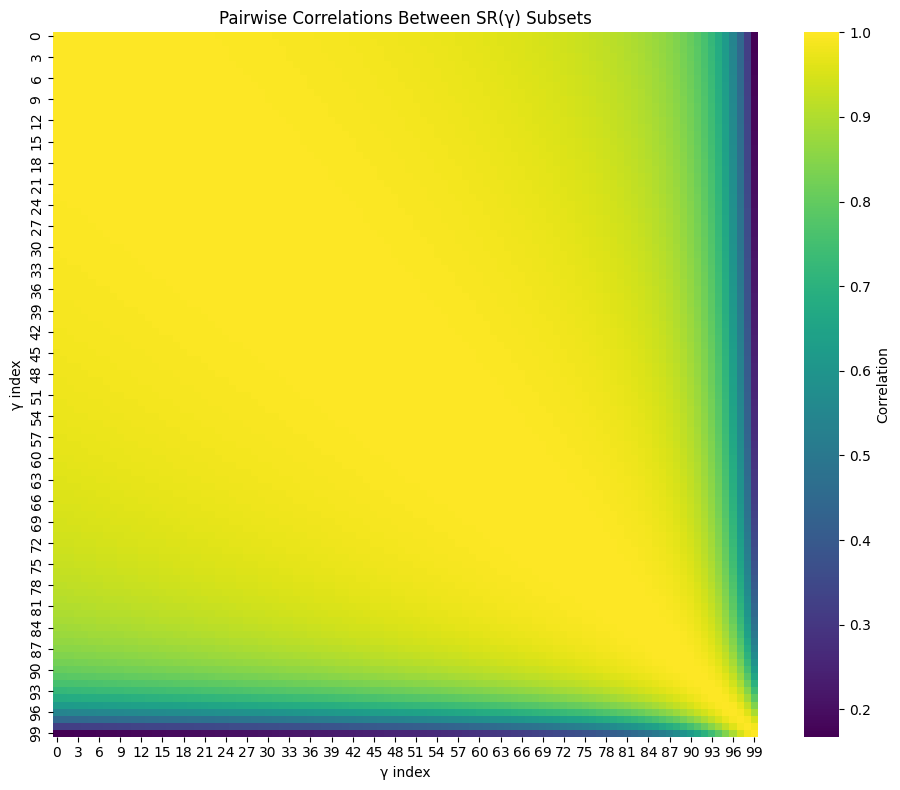

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="viridis", square=True, cbar_kws={'label': 'Correlation'})
plt.title("Pairwise Correlations Between SR(γ) Subsets")
plt.xlabel("γ index")
plt.ylabel("γ index")
plt.tight_layout()
plt.show()

What we see from the 100 x 100 correlation matrix is that the SR matrices seem to be highly correlated. The heatmap suggests that even SR matrices from very different γ values are highly correlated. That means correlation is not a good discriminator here - not because the model is bad, but because correlation as a metric might not capture the differences that matter.

This is a good motivation to move to approach 2 and use mean squared error (MSE) instead of correlation. MSE cares about scale and magnitude, so it's more sensitive to the differences in SR values.

## Step 6: Z-scoring the vectors before correlation

If the only reason the SRs look similar is scaling, z-scoring might restore some structure in your correlation matrix.

In [15]:
from scipy.stats import zscore

In [16]:
SR_vectors_z = [zscore(vec) for vec in SR_vectors]

correlation_matrix_z = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        correlation_matrix_z[i, j] = np.corrcoef(SR_vectors_z[i], SR_vectors_z[j])[0, 1]

Let's visualize the z-scored correlation matrix!

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

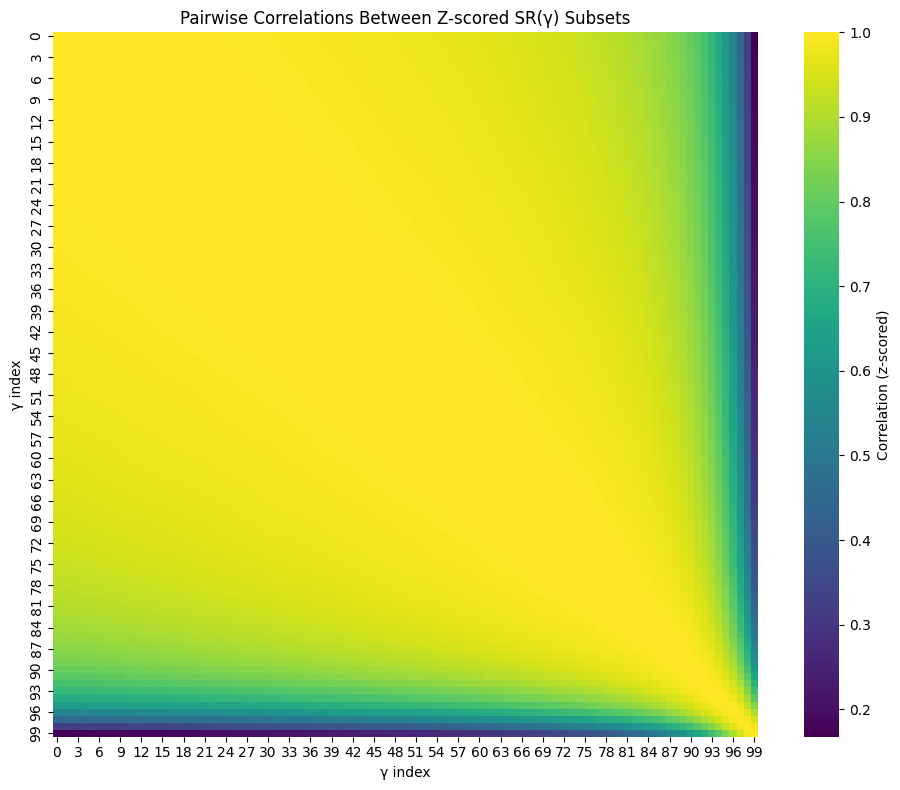

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_z, cmap="viridis", square=True, cbar_kws={'label': 'Correlation (z-scored)'})
plt.title("Pairwise Correlations Between Z-scored SR(γ) Subsets")
plt.xlabel("γ index")
plt.ylabel("γ index")
plt.tight_layout()
plt.show()

Interpretation:

*   The SR matrices still look quite similar across γ — not just because of scale, but because the underlying structure varies gradually and smoothly.
*   This smooth gradient of similarity is inherent to the SR model: small changes in γ lead to small changes in the SR matrix.

Verdict: Correlation, even with z-scoring, may not be sensitive enough to pick up meaningful differences between these highly structured matrices.